In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_TREATMENT_NAME": treatment,
        "MILL_REPLICATE": replicate,
    }
    for treatment in ["bag", "ring", "allopatry"]
    for replicate in range(10)
]


for i, pp in enumerate(parameter_packs):
    with open(f"species-inference-parameterization-{i}.yaml", "w") as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_TREATMENT_NAME: str
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_REPLICATE = 8
MILL_TREATMENT_NAME = "allopatry"


# Global Setup


In [5]:
import copy
import math
import itertools as it
import typing
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools

from hstrat import hstrat
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
import sympy
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


In [7]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
nbcellexec: null
nbname: None
nbpath: None
revision: null
session: 8144679f-79fd-48c8-a3d6-2c1ecfc4ad7c
timestamp: 2023-05-23T19:13:30Z00:00




IPython==7.31.1
keyname==0.5.2
yaml==6.0
Bio==1.79
alifedata_phyloinformatics_convert==0.13.0
deap==1.3
endomill==0.1.3
hstrat==1.6.1
iterpop==0.4.1
matplotlib==3.6.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.5.2
scipy==1.10.1
seaborn==0.12.1
sympy==1.9
teeplot==0.5.0
re==2.2.1
debugpy==1.6.6
logging==0.5.1.2
psutil==5.9.0
zmq==22.3.0
json==2.0.9
ipykernel==6.7.0


# Parameters


In [8]:
HSTRAT_DIFFERENTIA_WIDTH = 64
NGEN = 200
NPOP = 100
NTOURN = 2


# Setup


In [9]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register(
    "individual",
    deap_tools.initRepeat,
    deap_creator.Individual,
    toolbox.attr_bool,
    n=100,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (sum(individual),)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", deap_tools.cxTwoPoint)
toolbox.register("mutate", deap_tools.mutFlipBit, indpb=0.05)
toolbox.register("select", deap_tools.selTournament, tournsize=NTOURN)

# Decorate the variation operators
history = deap_tools.History()
toolbox.decorate("mate", history.decorator)

toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [10]:
# Create the population and populate the history
population = toolbox.population(n=NPOP)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
gene_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
    initial_stratum_annotation=0,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = gene_ancestor.CloneDescendant(0)

history.update(population)

# Do the evolution, the decorators will take care of updating the
# history
if MILL_TREATMENT_NAME == "bag":
    for _gen in range(NGEN):
        offspring = deap_algorithms.varAnd(
            population,
            toolbox,
            cxpb=1.0,
            mutpb=1.0,
        )
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=NPOP)
        population = [copy.deepcopy(ind) for ind in population]

elif MILL_TREATMENT_NAME == "ring":
    NUM_ISLANDS = 10
    NUM_MIGRATIONS = 1
    slice_size = len(population) // NUM_ISLANDS
    for gen in tqdm(range(NGEN)):
        for slice_ in pylib.util.iter_slices(len(population), slice_size):
            subpopulation = population[slice_]
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            population[slice_] = [copy.deepcopy(ind) for ind in subpopulation]

        for m in range(NUM_MIGRATIONS):
            displacement = random.randrange(slice_size, 2 * slice_size)
            a = random.randrange(len(population))
            b = (a + displacement) % len(population)
            population[a], population[b] = population[b], population[a]

    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

elif MILL_TREATMENT_NAME == "allopatry":
    # sympatry
    for gen in tqdm(range(NGEN // 2)):
        offspring = deap_algorithms.varAnd(
            population, toolbox, cxpb=1.0, mutpb=1.0
        )
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        population = [copy.deepcopy(ind) for ind in population]

    # two-island allopatry
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

    # three-island allopatry: left island
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population) // 2, slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    # three-island allopatry: right five islands
    slice_size = NPOP // 10
    for i in range(len(population) // 2, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    population = from_subpopulations

else:
    assert False, MILL_TREATMENT_NAME

# ensure all extant organisms registered with phylogeny tracker
for x in population:
    history.update([x])


  0%|                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                       | 1/100 [00:00<01:18,  1.26it/s]

  2%|███                                                                                                                                                      | 2/100 [00:01<01:04,  1.51it/s]

  3%|████▌                                                                                                                                                    | 3/100 [00:01<01:00,  1.59it/s]

  4%|██████                                                                                                                                                   | 4/100 [00:02<01:09,  1.38it/s]

  5%|███████▋                                                                                                                                                 | 5/100 [00:03<01:06,  1.44it/s]

  6%|█████████▏                                                                                                                                               | 6/100 [00:04<01:04,  1.46it/s]

  7%|██████████▋                                                                                                                                              | 7/100 [00:04<01:03,  1.46it/s]

  8%|████████████▏                                                                                                                                            | 8/100 [00:05<01:12,  1.28it/s]

  9%|█████████████▊                                                                                                                                           | 9/100 [00:06<01:10,  1.30it/s]

 10%|███████████████▏                                                                                                                                        | 10/100 [00:07<01:09,  1.29it/s]

 11%|████████████████▋                                                                                                                                       | 11/100 [00:08<01:09,  1.28it/s]

 12%|██████████████████▏                                                                                                                                     | 12/100 [00:09<01:17,  1.13it/s]

 13%|███████████████████▊                                                                                                                                    | 13/100 [00:10<01:15,  1.15it/s]

 14%|█████████████████████▎                                                                                                                                  | 14/100 [00:10<01:14,  1.15it/s]

 15%|██████████████████████▊                                                                                                                                 | 15/100 [00:12<01:23,  1.02it/s]

 16%|████████████████████████▎                                                                                                                               | 16/100 [00:13<01:21,  1.04it/s]

 17%|█████████████████████████▊                                                                                                                              | 17/100 [00:14<01:19,  1.04it/s]

 18%|███████████████████████████▎                                                                                                                            | 18/100 [00:15<01:19,  1.03it/s]

 19%|████████████████████████████▉                                                                                                                           | 19/100 [00:16<01:28,  1.09s/it]

 20%|██████████████████████████████▍                                                                                                                         | 20/100 [00:17<01:25,  1.07s/it]

 21%|███████████████████████████████▉                                                                                                                        | 21/100 [00:18<01:24,  1.07s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 22/100 [00:19<01:23,  1.07s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 23/100 [00:21<01:32,  1.20s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 24/100 [00:22<01:30,  1.19s/it]

 25%|██████████████████████████████████████                                                                                                                  | 25/100 [00:23<01:28,  1.18s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 26/100 [00:24<01:28,  1.19s/it]

 27%|█████████████████████████████████████████                                                                                                               | 27/100 [00:26<01:36,  1.32s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 28/100 [00:27<01:33,  1.31s/it]

 29%|████████████████████████████████████████████                                                                                                            | 29/100 [00:28<01:32,  1.30s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 30/100 [00:30<01:40,  1.43s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 31/100 [00:31<01:36,  1.40s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 32/100 [00:33<01:32,  1.37s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 33/100 [00:34<01:31,  1.37s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 34/100 [00:35<01:30,  1.38s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 35/100 [00:37<01:39,  1.54s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 36/100 [00:39<01:37,  1.52s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 37/100 [00:40<01:35,  1.51s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 38/100 [00:42<01:33,  1.51s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 39/100 [00:44<01:41,  1.67s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 40/100 [00:45<01:38,  1.64s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 41/100 [00:47<01:35,  1.63s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 42/100 [00:49<01:34,  1.63s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 43/100 [00:51<01:42,  1.80s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 44/100 [00:53<01:38,  1.76s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 45/100 [00:54<01:35,  1.74s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 46/100 [00:56<01:33,  1.74s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 47/100 [00:58<01:41,  1.92s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 48/100 [01:00<01:37,  1.88s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 49/100 [01:02<01:34,  1.86s/it]

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 50/100 [01:04<01:32,  1.86s/it]

 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 51/100 [01:06<01:31,  1.87s/it]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 52/100 [01:08<01:38,  2.06s/it]

 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 53/100 [01:10<01:29,  1.90s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 54/100 [01:12<01:28,  1.92s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                    | 55/100 [01:14<01:27,  1.94s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                   | 56/100 [01:16<01:36,  2.20s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 57/100 [01:19<01:33,  2.17s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 58/100 [01:21<01:30,  2.15s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 59/100 [01:23<01:28,  2.16s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 60/100 [01:25<01:26,  2.17s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 61/100 [01:28<01:32,  2.37s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 62/100 [01:30<01:29,  2.34s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 63/100 [01:32<01:26,  2.33s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 64/100 [01:35<01:22,  2.30s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 65/100 [01:37<01:20,  2.30s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 66/100 [01:40<01:26,  2.55s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 67/100 [01:42<01:22,  2.51s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 68/100 [01:45<01:19,  2.49s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 69/100 [01:47<01:16,  2.48s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 70/100 [01:50<01:14,  2.48s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 71/100 [01:53<01:18,  2.70s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 72/100 [01:55<01:08,  2.45s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 73/100 [01:57<01:01,  2.27s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 74/100 [01:59<00:55,  2.15s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 75/100 [02:01<00:51,  2.07s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 76/100 [02:03<00:53,  2.24s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 77/100 [02:05<00:49,  2.16s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 78/100 [02:07<00:46,  2.11s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 79/100 [02:09<00:43,  2.08s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 80/100 [02:11<00:41,  2.05s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 81/100 [02:14<00:43,  2.27s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 82/100 [02:16<00:39,  2.21s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 83/100 [02:18<00:37,  2.18s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 84/100 [02:20<00:34,  2.17s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 85/100 [02:22<00:32,  2.16s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 86/100 [02:25<00:33,  2.38s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 87/100 [02:28<00:30,  2.34s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 88/100 [02:29<00:26,  2.21s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 89/100 [02:32<00:24,  2.21s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 90/100 [02:34<00:22,  2.23s/it]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 91/100 [02:36<00:20,  2.23s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [02:39<00:20,  2.51s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 93/100 [02:42<00:18,  2.58s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 94/100 [02:45<00:16,  2.78s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 95/100 [02:49<00:14,  2.93s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [02:52<00:12,  3.04s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [02:55<00:09,  3.13s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [03:00<00:07,  3.54s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [03:03<00:03,  3.50s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  3.48s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:01<01:24,  1.73s/it]

  4%|██████▏                                                                                                                                                   | 2/50 [00:03<01:23,  1.73s/it]

  6%|█████████▏                                                                                                                                                | 3/50 [00:05<01:20,  1.72s/it]

  8%|████████████▎                                                                                                                                             | 4/50 [00:06<01:19,  1.73s/it]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:08<01:18,  1.75s/it]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:11<01:36,  2.18s/it]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:13<01:28,  2.07s/it]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:15<01:23,  2.00s/it]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:17<01:20,  1.95s/it]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:19<01:17,  1.93s/it]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:21<01:14,  1.92s/it]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:22<01:12,  1.90s/it]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:24<01:10,  1.90s/it]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:26<01:08,  1.91s/it]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:28<01:07,  1.92s/it]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:30<01:05,  1.92s/it]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:32<01:03,  1.93s/it]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:35<01:14,  2.33s/it]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:37<01:09,  2.23s/it]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:39<01:05,  2.17s/it]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:41<01:01,  2.13s/it]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:43<00:58,  2.10s/it]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:45<00:56,  2.08s/it]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:47<00:53,  2.07s/it]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:50<00:52,  2.08s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:52<00:49,  2.06s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:54<00:47,  2.07s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:56<00:45,  2.08s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:59<00:52,  2.52s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [01:01<00:48,  2.41s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [01:04<00:44,  2.34s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [01:06<00:41,  2.29s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [01:08<00:38,  2.26s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [01:10<00:35,  2.20s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [01:12<00:32,  2.20s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [01:15<00:30,  2.21s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [01:17<00:28,  2.21s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [01:19<00:26,  2.22s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [01:23<00:29,  2.70s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [01:25<00:25,  2.58s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [01:27<00:22,  2.50s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [01:30<00:19,  2.44s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [01:32<00:16,  2.41s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [01:34<00:14,  2.41s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [01:37<00:11,  2.40s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [01:39<00:09,  2.39s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [01:42<00:07,  2.40s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [01:44<00:04,  2.25s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [01:45<00:02,  2.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  1.98s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.15s/it]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:02<02:02,  2.51s/it]

  4%|██████▏                                                                                                                                                   | 2/50 [00:03<01:25,  1.78s/it]

  6%|█████████▏                                                                                                                                                | 3/50 [00:05<01:12,  1.55s/it]

  8%|████████████▎                                                                                                                                             | 4/50 [00:06<01:06,  1.44s/it]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:07<01:02,  1.40s/it]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:08<00:59,  1.36s/it]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:10<00:57,  1.35s/it]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:11<00:56,  1.34s/it]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:12<00:54,  1.33s/it]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:14<00:53,  1.34s/it]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:15<00:52,  1.34s/it]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:16<00:51,  1.35s/it]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:18<00:50,  1.36s/it]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:19<00:48,  1.36s/it]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:22<01:02,  1.78s/it]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:23<00:56,  1.67s/it]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:25<00:52,  1.60s/it]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:26<00:49,  1.54s/it]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:28<00:46,  1.51s/it]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:29<00:44,  1.50s/it]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:31<00:43,  1.49s/it]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:32<00:41,  1.48s/it]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:34<00:40,  1.48s/it]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:35<00:38,  1.49s/it]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:37<00:37,  1.49s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:38<00:36,  1.50s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:40<00:34,  1.51s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:41<00:33,  1.51s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:45<00:44,  2.12s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:47<00:43,  2.16s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:49<00:41,  2.17s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:51<00:39,  2.18s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:54<00:37,  2.20s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:56<00:35,  2.21s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:58<00:33,  2.22s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [01:00<00:31,  2.23s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [01:03<00:29,  2.24s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [01:05<00:26,  2.23s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [01:07<00:24,  2.25s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [01:09<00:22,  2.26s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [01:12<00:20,  2.28s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [01:14<00:18,  2.29s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [01:16<00:16,  2.30s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [01:21<00:17,  2.95s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [01:23<00:13,  2.79s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [01:26<00:10,  2.67s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [01:28<00:07,  2.61s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [01:30<00:05,  2.56s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [01:33<00:02,  2.54s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  2.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.92s/it]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:02<02:02,  2.51s/it]

  4%|██████▏                                                                                                                                                   | 2/50 [00:05<02:00,  2.50s/it]

  6%|█████████▏                                                                                                                                                | 3/50 [00:07<01:57,  2.50s/it]

  8%|████████████▎                                                                                                                                             | 4/50 [00:09<01:54,  2.50s/it]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:12<01:53,  2.53s/it]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:15<01:51,  2.54s/it]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:17<01:49,  2.55s/it]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:22<02:16,  3.24s/it]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:25<02:05,  3.06s/it]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:27<01:56,  2.92s/it]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:30<01:51,  2.85s/it]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:33<01:46,  2.80s/it]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:35<01:42,  2.76s/it]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:38<01:37,  2.69s/it]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:40<01:33,  2.66s/it]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:43<01:29,  2.63s/it]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:45<01:26,  2.61s/it]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:48<01:23,  2.61s/it]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:51<01:21,  2.62s/it]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:53<01:18,  2.62s/it]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:56<01:16,  2.62s/it]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:59<01:13,  2.64s/it]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [01:04<01:29,  3.33s/it]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [01:06<01:21,  3.14s/it]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [01:09<01:15,  3.02s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [01:12<01:10,  2.93s/it]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [01:15<01:06,  2.87s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [01:17<01:02,  2.85s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [01:20<00:59,  2.85s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [01:23<00:55,  2.79s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [01:26<00:52,  2.77s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [01:28<00:50,  2.78s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [01:31<00:47,  2.79s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [01:33<00:41,  2.62s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [01:35<00:36,  2.45s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [01:38<00:32,  2.34s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [01:42<00:36,  2.84s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [01:44<00:31,  2.62s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [01:46<00:27,  2.46s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [01:48<00:23,  2.37s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [01:50<00:20,  2.31s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [01:52<00:18,  2.27s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [01:54<00:15,  2.25s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [01:57<00:13,  2.24s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [01:59<00:11,  2.23s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [02:01<00:08,  2.22s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [02:03<00:06,  2.18s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [02:05<00:04,  2.16s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [02:08<00:02,  2.20s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.23s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.61s/it]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:00<00:17,  2.76it/s]

  4%|██████▏                                                                                                                                                   | 2/50 [00:00<00:17,  2.75it/s]

  6%|█████████▏                                                                                                                                                | 3/50 [00:01<00:17,  2.73it/s]

  8%|████████████▎                                                                                                                                             | 4/50 [00:01<00:16,  2.72it/s]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:01<00:16,  2.70it/s]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:02<00:16,  2.69it/s]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:04<00:47,  1.11s/it]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:05<00:36,  1.14it/s]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:05<00:29,  1.39it/s]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:05<00:24,  1.63it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:06<00:21,  1.84it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:06<00:18,  2.02it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:07<00:17,  2.17it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:07<00:15,  2.27it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:07<00:14,  2.35it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:08<00:14,  2.41it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:08<00:13,  2.44it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:09<00:12,  2.47it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:09<00:12,  2.47it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:09<00:12,  2.35it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:10<00:13,  2.18it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:11<00:13,  2.03it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:11<00:13,  1.94it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:12<00:13,  1.88it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:12<00:13,  1.82it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:13<00:13,  1.78it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:13<00:12,  1.77it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:14<00:12,  1.76it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:15<00:12,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:15<00:11,  1.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:16<00:11,  1.69it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:16<00:09,  1.93it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:17<00:07,  2.23it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:17<00:06,  2.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:17<00:05,  2.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [00:17<00:05,  2.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [00:18<00:04,  2.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [00:18<00:04,  2.94it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [00:19<00:03,  2.77it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [00:19<00:03,  2.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [00:19<00:03,  2.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [00:19<00:02,  2.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [00:20<00:02,  2.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [00:20<00:02,  2.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [00:21<00:02,  2.33it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [00:21<00:01,  2.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [00:22<00:01,  1.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [00:23<00:01,  1.78it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [00:23<00:00,  1.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  1.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:00<00:21,  2.27it/s]

  4%|██████▏                                                                                                                                                   | 2/50 [00:00<00:21,  2.22it/s]

  6%|█████████▏                                                                                                                                                | 3/50 [00:01<00:22,  2.13it/s]

  8%|████████████▎                                                                                                                                             | 4/50 [00:01<00:21,  2.10it/s]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:02<00:21,  2.07it/s]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:02<00:21,  2.04it/s]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:03<00:20,  2.09it/s]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:03<00:18,  2.22it/s]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:04<00:19,  2.13it/s]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:04<00:19,  2.05it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:05<00:19,  2.01it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:05<00:19,  1.99it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:06<00:18,  1.98it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:06<00:18,  1.94it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:07<00:18,  1.94it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:07<00:17,  1.95it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:08<00:17,  1.93it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:08<00:16,  1.89it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:09<00:15,  2.03it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:09<00:14,  2.10it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:10<00:12,  2.38it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:10<00:11,  2.40it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:11<00:12,  2.14it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:11<00:12,  2.04it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:12<00:12,  1.94it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:12<00:12,  1.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:13<00:12,  1.77it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:14<00:12,  1.74it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:14<00:12,  1.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:15<00:11,  1.72it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:15<00:11,  1.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:16<00:10,  1.73it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:16<00:09,  1.71it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:17<00:09,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:18<00:08,  1.68it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [00:18<00:07,  1.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [00:19<00:06,  1.93it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [00:19<00:06,  1.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [00:20<00:06,  1.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [00:20<00:05,  1.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [00:23<00:11,  1.26s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [00:24<00:08,  1.06s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [00:24<00:06,  1.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [00:25<00:04,  1.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [00:26<00:03,  1.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [00:26<00:02,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [00:27<00:01,  1.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [00:27<00:01,  1.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [00:28<00:00,  1.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:00<00:21,  2.32it/s]

  4%|██████▏                                                                                                                                                   | 2/50 [00:00<00:23,  2.07it/s]

  6%|█████████▏                                                                                                                                                | 3/50 [00:01<00:23,  1.98it/s]

  8%|████████████▎                                                                                                                                             | 4/50 [00:02<00:23,  1.95it/s]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:02<00:23,  1.94it/s]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:03<00:22,  1.92it/s]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:03<00:22,  1.94it/s]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:04<00:22,  1.90it/s]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:04<00:21,  1.88it/s]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:05<00:21,  1.89it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:05<00:20,  1.88it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:06<00:20,  1.89it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:06<00:19,  1.88it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:07<00:19,  1.87it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:07<00:18,  1.88it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:08<00:18,  1.85it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:08<00:18,  1.83it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:09<00:17,  1.81it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:10<00:17,  1.79it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:10<00:16,  1.78it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:11<00:16,  1.79it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:11<00:15,  1.77it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:12<00:15,  1.77it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:12<00:14,  1.77it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:13<00:14,  1.77it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:14<00:13,  1.81it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:14<00:12,  1.79it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:15<00:12,  1.73it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:15<00:12,  1.71it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:16<00:11,  1.71it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:17<00:11,  1.68it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:17<00:10,  1.68it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:18<00:10,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:18<00:09,  1.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:19<00:09,  1.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [00:20<00:08,  1.62it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [00:20<00:07,  1.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [00:20<00:05,  2.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [00:21<00:05,  1.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [00:22<00:05,  1.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [00:22<00:05,  1.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [00:23<00:04,  1.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [00:23<00:04,  1.69it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [00:24<00:03,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [00:25<00:03,  1.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [00:25<00:02,  1.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [00:26<00:01,  1.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [00:27<00:01,  1.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [00:27<00:00,  1.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:00<00:23,  2.06it/s]

  4%|██████▏                                                                                                                                                   | 2/50 [00:00<00:24,  2.00it/s]

  6%|█████████▏                                                                                                                                                | 3/50 [00:01<00:23,  2.01it/s]

  8%|████████████▎                                                                                                                                             | 4/50 [00:02<00:23,  1.98it/s]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:02<00:22,  1.98it/s]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:03<00:22,  1.96it/s]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:03<00:21,  1.97it/s]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:04<00:21,  2.00it/s]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:04<00:17,  2.32it/s]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:04<00:16,  2.45it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:04<00:14,  2.72it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:05<00:12,  2.96it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:05<00:11,  3.17it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:05<00:11,  3.15it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:06<00:11,  3.15it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:06<00:10,  3.12it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:06<00:10,  3.24it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:06<00:09,  3.34it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:07<00:09,  3.26it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:07<00:09,  3.13it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:07<00:08,  3.25it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:08<00:08,  3.21it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:08<00:08,  3.23it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:08<00:08,  3.16it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:09<00:07,  3.16it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:09<00:07,  3.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:09<00:07,  3.27it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:10<00:06,  3.33it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:10<00:06,  3.23it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:10<00:06,  3.31it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:11<00:06,  3.15it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:14<00:19,  1.10s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:14<00:15,  1.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:15<00:13,  1.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:15<00:11,  1.33it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [00:16<00:09,  1.42it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [00:16<00:08,  1.50it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [00:17<00:07,  1.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [00:18<00:06,  1.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [00:18<00:06,  1.61it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [00:19<00:05,  1.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [00:19<00:04,  1.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [00:20<00:04,  1.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [00:21<00:03,  1.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [00:21<00:03,  1.58it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [00:22<00:02,  1.72it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [00:22<00:01,  1.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [00:23<00:01,  1.79it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [00:23<00:00,  1.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 1/50 [00:00<00:24,  2.04it/s]

  4%|██████▏                                                                                                                                                   | 2/50 [00:00<00:22,  2.16it/s]

  6%|█████████▏                                                                                                                                                | 3/50 [00:01<00:23,  2.03it/s]

  8%|████████████▎                                                                                                                                             | 4/50 [00:01<00:23,  1.99it/s]

 10%|███████████████▍                                                                                                                                          | 5/50 [00:02<00:23,  1.92it/s]

 12%|██████████████████▍                                                                                                                                       | 6/50 [00:02<00:20,  2.18it/s]

 14%|█████████████████████▌                                                                                                                                    | 7/50 [00:03<00:20,  2.06it/s]

 16%|████████████████████████▋                                                                                                                                 | 8/50 [00:03<00:21,  1.95it/s]

 18%|███████████████████████████▋                                                                                                                              | 9/50 [00:04<00:20,  1.98it/s]

 20%|██████████████████████████████▌                                                                                                                          | 10/50 [00:04<00:20,  1.98it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 11/50 [00:05<00:19,  2.05it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 12/50 [00:05<00:18,  2.01it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 13/50 [00:06<00:18,  2.01it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 14/50 [00:06<00:18,  1.98it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 15/50 [00:07<00:17,  1.96it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 16/50 [00:08<00:17,  1.92it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 17/50 [00:08<00:17,  1.89it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 18/50 [00:09<00:17,  1.88it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 19/50 [00:09<00:16,  1.87it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 20/50 [00:10<00:16,  1.81it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 21/50 [00:10<00:16,  1.80it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 22/50 [00:11<00:15,  1.84it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 23/50 [00:11<00:14,  1.82it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 24/50 [00:12<00:14,  1.82it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/50 [00:13<00:14,  1.76it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 26/50 [00:13<00:13,  1.73it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 27/50 [00:14<00:13,  1.73it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 28/50 [00:14<00:12,  1.74it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 29/50 [00:15<00:11,  1.90it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 30/50 [00:15<00:10,  1.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 31/50 [00:16<00:10,  1.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 32/50 [00:16<00:10,  1.79it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 33/50 [00:17<00:09,  1.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 34/50 [00:18<00:09,  1.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 35/50 [00:18<00:08,  1.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 36/50 [00:19<00:08,  1.74it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 37/50 [00:19<00:07,  1.77it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 38/50 [00:20<00:06,  1.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 39/50 [00:20<00:06,  1.73it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 40/50 [00:21<00:05,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 41/50 [00:22<00:05,  1.68it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 42/50 [00:22<00:04,  1.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 43/50 [00:23<00:04,  1.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44/50 [00:24<00:03,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45/50 [00:24<00:02,  1.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46/50 [00:25<00:02,  1.68it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [00:25<00:01,  1.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48/50 [00:26<00:01,  1.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [00:27<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.81it/s]

# Reconstruction


In [11]:
extant_nodes = [individual.history_index for individual in population]
reconstructed_df = hstrat.build_tree(
    [individual.species_annotation for individual in population],
    version_pin=hstrat.__version__,
    force_common_ancestry=True,
    taxon_labels=map(str, extant_nodes),
)
reconstructed_df["name"] = reconstructed_df["taxon_label"]
reconstructed_df.to_csv(
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".csv",
        }
    )
)
reconstructed_df


,id,ancestor_list,origin_time,taxon_label,ancestor_id,name
0,0,[none],0.0,Root,0,Root
100,100,[0],99.0,Inner+r=99+d=P3KrNbmQPwa+uid=Bm_sCG3yKWUJy0caV...,0,Inner+r=99+d=P3KrNbmQPwa+uid=Bm_sCG3yKWUJy0caV...
198,198,[100],148.0,Inner+r=148+d=O5JoyAFBOtT+uid=CcVGSWvkfMekRgVr...,100,Inner+r=148+d=O5JoyAFBOtT+uid=CcVGSWvkfMekRgVr...
200,200,[198],149.0,Inner+r=149+d=O2OZwB5qeZP+uid=SgTfqwJC8hPjsriS...,198,Inner+r=149+d=O2OZwB5qeZP+uid=SgTfqwJC8hPjsriS...
201,201,[198],149.0,Inner+r=149+d=OzscbdcrcKH+uid=DOtS_DtdTORXyWmS...,198,Inner+r=149+d=OzscbdcrcKH+uid=DOtS_DtdTORXyWmS...
...,...,...,...,...,...,...
802,802,[605],201.0,20197,605,20197
803,803,[605],201.0,20194,605,20194
804,804,[605],201.0,20192,605,20192
805,805,[606],201.0,20195,606,20195


teeplots/./notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.png


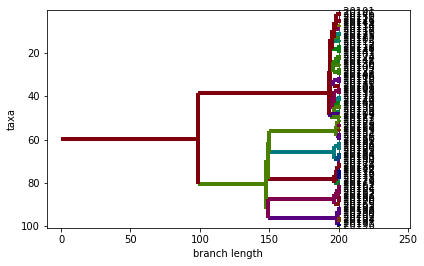

In [12]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
BioPhylo.write(
    reconstructed_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".nwk",
        }
    ),
    'newick',
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.png


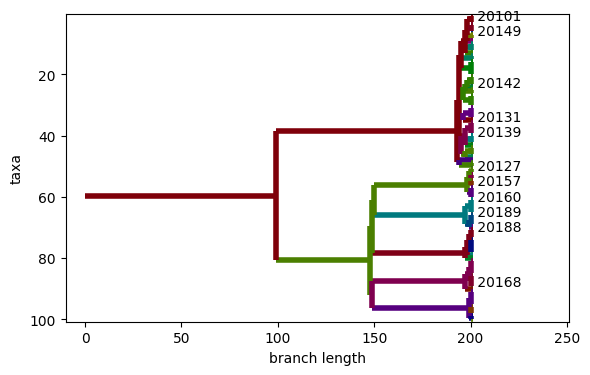

In [13]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=8+treatment=allopatry+type=reconstruction+viz=draw-biopython-tree+ext=.png


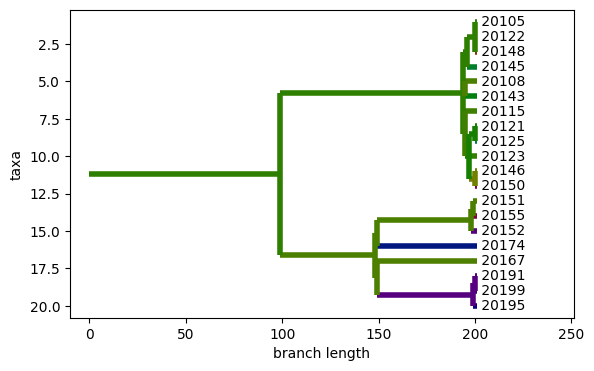

In [14]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


# Actual Pedigree


In [15]:
distilled_tree = pylib.deap.history_to_tree_upgma(history, extant_nodes)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree",
            "ext": ".nwk",
        }
    ),
    'newick',
)


1

teeplots/./notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.png


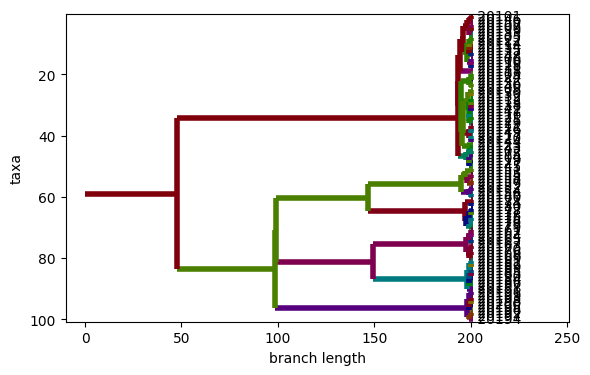

In [16]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.png


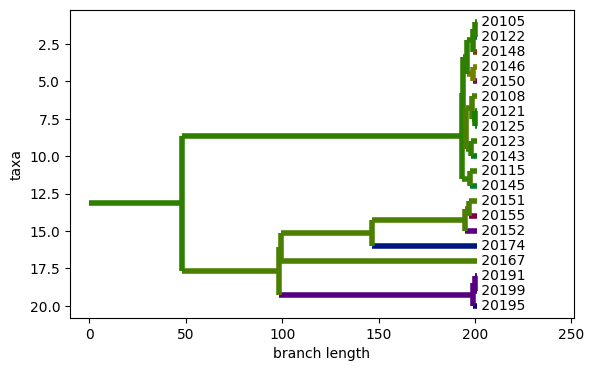

In [17]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=8+treatment=allopatry+type=distilled-reference+viz=draw-biopython-tree+ext=.png


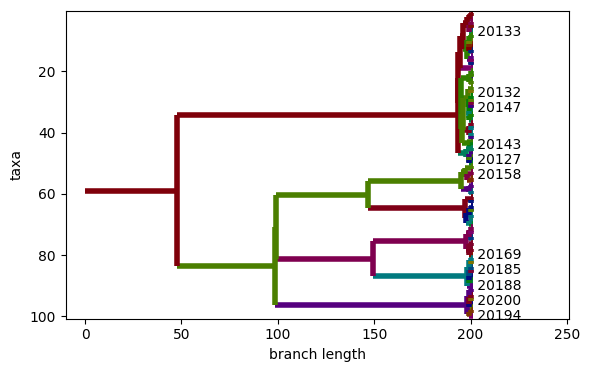

In [18]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


In [19]:
distilled_tree = pylib.deap.history_to_tree_upgma(
    history, extant_nodes, correct_origin_times=False
)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree-uncorrected",
            "ext": ".nwk",
        }
    ),
    'newick',
)

quartet_dist = pylib.tree.polymorphic_quartet_distance(
    reconstructed_tree, distilled_tree
)
quartet_dist


0.2774301398160014

In [20]:
records = [
    {
        "replicate": MILL_REPLICATE,
        "treatment": MILL_TREATMENT_NAME,
        "quartet distance": quartet_dist,
    }
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "reconstruction-accuracy",
            "notebook": "species-inference",
            "replicate": MILL_REPLICATE,
            "treatment": MILL_TREATMENT_NAME,
            "ext": ".csv",
        }
    )
)
outdf


,replicate,treatment,quartet distance
0,8,allopatry,0.27743
